In [ ]:
# import libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random

In [ ]:
# Read CSV file and store into a DF
df = pd.read_csv("/Users/Marcy_Student/Desktop/Mod4_FinalProject/data/hour.csv" )
df.head()


In [ ]:
# Get a feel for the data
df.info()
df.describe(include='all')

In [ ]:
# Convert dates into datetime in order for it to be usable
df['dteday'] = pd.to_datetime(df['dteday'])
df['weekday'] = df['weekday'].astype(int)  
df['workingday'] = df['workingday'].astype(int)
df.head()

In [ ]:
# Visual 1: Average Hourly Rides during Working and Non-Working Days
vis1 = df.groupby(['hr','workingday'])['cnt'].mean().reset_index()
sns.lineplot(data=vis1, x='hr', y='cnt', hue='workingday', marker='o')
plt.title('Average Hourly Rides — Workingday (1) vs Non-Workingday (0)')
plt.xlabel('Hour of day')
x = np.arange(0, 24, 1)
plt.xticks(x)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Average count')
plt.legend(title='workingday')
plt.tight_layout()
plt.savefig('/Users/Marcy_Student/Desktop/Mod4_FinalProject/figures/vis_avg_hour_workingday.png', dpi=150)

In [ ]:
# Visual 2: Registered vs casual split over hours
agg = df.groupby('hr')[['registered','casual']].mean().reset_index()
x = np.arange(0, 24, 1)
plt.xticks(x)
plt.xticks(rotation=90, ha='right')
sns.lineplot(data=agg, x='hr', y='registered', label='registered', marker='o')
sns.lineplot(data=agg, x='hr', y='casual', label='casual',marker='o')
plt.xlabel('Hour of day')
plt.ylabel('Status')
plt.title('Avg registered vs casual rides by hour')
plt.savefig('/Users/Marcy_Student/Desktop/Mod4_FinalProject/figures/vis_reg_casual_by_hour.png', dpi=150)

In [ ]:
agg = df.groupby('season')['cnt'].mean().reset_index()
plt.figure(figsize=(6,4))
max_val = agg['cnt'].max()

colors = ['green' if v == max_val else 'lightgray' for v in agg['cnt']]
sns.barplot(data=agg, x='season', y='cnt', palette=colors)
plt.title('Average Riders by Season')
plt.xlabel('Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)')
plt.ylabel('Avg Riders')
plt.tight_layout()
plt.savefig('/Users/Marcy_Student/Desktop/Mod4_FinalProject/figures/avg_riders_by_season.png', dpi=150)
plt.show()

/opt/miniconda3/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/opt/miniconda3/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/opt/miniconda3/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


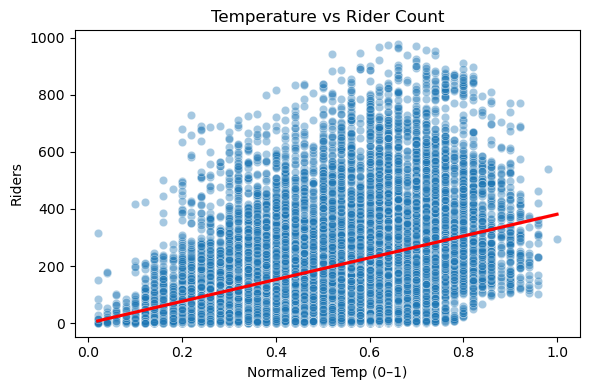

In [22]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='temp', y='cnt', alpha=0.4)
sns.regplot(data=df, x='temp', y='cnt', scatter=False, color='red')
plt.title('Temperature vs Rider Count')
plt.xlabel('Normalized Temp (0–1)')
plt.ylabel('Riders')
plt.tight_layout()
plt.savefig('/Users/Marcy_Student/Desktop/Mod4_FinalProject/figures/temp_vs_riderCount.png', dpi=150)
plt.show()

In [ ]:
#Q1 - Welch Test 
import scipy.stats as stats # imports stats lib

working = df[df['workingday']==1]['cnt']
non_working = df[df['workingday']==0]['cnt']

# Welch's t-test
t_stat, p_val = stats.ttest_ind(working, non_working, equal_var=False)

# sample mean diff
mean_diff = working.mean() - non_working.mean()
# standard error
se = np.sqrt(working.var(ddof=1)/len(working) + non_working.var(ddof=1)/len(non_working))
ci_low, ci_high = mean_diff - 1.96*se, mean_diff + 1.96*se

print("Q1 — Working vs Non-Working Day")
print('Working Mean: ',working.mean(),', Non-Working Mean:', non_working.mean())
print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.5f}")
print(f"95% CI for mean difference: ({ci_low:.2f}, {ci_high:.2f})")


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA
model = ols('cnt ~ C(season)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\nQ2 — ANOVA by Season")
print(anova_table)

In [ ]:
# Part C — Simulated A/B Test (SPECIFIED)
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.weightstats import _tconfint_generic

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

df['dteday'] = pd.to_datetime(df['dteday'])

# ---------- Eligibility filter ----------
eligible = df[
    (df['workingday'] == 1) &
    (df['hr'].isin([17, 18, 19])) &
    (df['weathersit'].isin([1, 2])) &
    (df['hum'] <= 0.70)
].copy()

launch = pd.Timestamp('2012-09-01')
pre_start = pd.Timestamp('2012-08-04')
pre_end = pd.Timestamp('2012-08-31')
post_start = pd.Timestamp('2012-09-01')
post_end = pd.Timestamp('2012-09-28')

eligible = eligible[(eligible['dteday'] >= pre_start) & (eligible['dteday'] <= post_end)]

eligible['window'] = None
eligible.loc[(eligible['dteday'] >= pre_start) & (eligible['dteday'] <= pre_end), 'window'] = 'Pre'
eligible.loc[(eligible['dteday'] >= post_start) & (eligible['dteday'] <= post_end), 'window'] = 'Post'
eligible = eligible.dropna(subset=['window'])

eligible['slot'] = eligible['weekday'].astype(str) + '_' + eligible['hr'].astype(str)

pre = eligible[eligible['window'] == 'Pre']
post = eligible[eligible['window'] == 'Post']

slots = sorted(eligible['slot'].unique())
kept_pre_rows = []
kept_post_rows = []

for s in slots:
    pre_s = pre[pre['slot'] == s]
    post_s = post[post['slot'] == s]
    n_keep = min(len(pre_s), len(post_s))
    if n_keep == 0:
        continue
    pre_sel = pre_s.sample(n=n_keep, random_state=RANDOM_SEED)
    post_sel = post_s.sample(n=n_keep, random_state=RANDOM_SEED)
    kept_pre_rows.append(pre_sel)
    kept_post_rows.append(post_sel)

GroupA = pd.concat(kept_pre_rows, ignore_index=True)
GroupB = pd.concat(kept_post_rows, ignore_index=True)

# Balance tables 
balance_counts = pd.concat([
    GroupA.assign(Group='Pre')[['weekday','hr','Group']],
    GroupB.assign(Group='Post')[['weekday','hr','Group']]
])

balance_table = balance_counts.pivot_table(index=['weekday','hr'], columns='Group', aggfunc=len, values='Group', fill_value=0)

weather_mix = pd.concat([
    GroupA['weathersit'].value_counts().rename('Pre'),
    GroupB['weathersit'].value_counts().rename('Post')], axis=1).fillna(0).astype(int)

A_cnt = GroupA['cnt'].values
B_cnt = GroupB['cnt'].values

alpha = 0.05
t_stat, p_value = stats.ttest_ind(A_cnt, B_cnt, equal_var=False)

mean_diff = B_cnt.mean() - A_cnt.mean()
se = np.sqrt(A_cnt.var(ddof=1)/len(A_cnt) + B_cnt.var(ddof=1)/len(B_cnt))
df_num = (A_cnt.var(ddof=1)/len(A_cnt) + B_cnt.var(ddof=1)/len(B_cnt))**2
df_denom = (A_cnt.var(ddof=1)**2)/((len(A_cnt)**2)*(len(A_cnt)-1)) + (B_cnt.var(ddof=1)**2)/((len(B_cnt)**2)*(len(B_cnt)-1))
if df_denom == 0:
    dof = len(A_cnt) + len(B_cnt) - 2
else:
    dof = df_num / df_denom

ci_low, ci_upp = _tconfint_generic(mean_diff, se, dof, alpha, 'two-sided')

reject = p_value < alpha

practical_threshold = 5.0
practically_significant = (mean_diff >= practical_threshold)

guardrails = pd.DataFrame({
    'Pre': GroupA[['registered','casual','temp','hum','windspeed']].mean(),
    'Post': GroupB[['registered','casual','temp','hum','windspeed']].mean()
})

group_sizes = {'Pre': len(GroupA), 'Post': len(GroupB)}

balanced_groups = []

# Loop through each slot (weekday × hour)
for slot, grp in eligible.groupby(['weekday','hr']):
    pre_grp = grp[grp['window']=='Pre']
    post_grp = grp[grp['window']=='Post']
    n = min(len(pre_grp), len(post_grp))
    if n > 0:
        balanced_groups.append(pre_grp.sample(n, random_state=42))
        balanced_groups.append(post_grp.sample(n, random_state=42))

# Final balanced dataset
balanced = pd.concat(balanced_groups, ignore_index=True)


# summary
print('=== Balance table (weekday x hour) — counts per group ===')
print(balance_table)
print('\n=== Weather mix (weathersit counts) ===')
print(weather_mix)
print('\n=== Sample sizes ===')
print(group_sizes)
print('\n=== Primary metric: cnt comparison ===')
print(f'Pre mean cnt = {A_cnt.mean():.3f}, Post mean cnt = {B_cnt.mean():.3f}')
print(f'Mean difference (Post - Pre) = {mean_diff:.3f}')
print(f't-statistic = {t_stat:.4f}, p-value = {p_value:.4g}')
print(f'95% CI for mean difference = [{ci_low:.3f}, {ci_upp:.3f}]')
print('Reject H0?' , 'Yes' if reject else 'No')
print('Practically significant (>= +5 rides/hr)?', 'Yes' if practically_significant else 'No')
print('\n=== Guardrail metrics (group means) ===')
print(guardrails)


GroupA.to_csv('GroupA_selected.csv', index=False)
GroupB.to_csv('GroupB_selected.csv', index=False)
balance_table.to_csv('balance_table.csv')
weather_mix.to_csv('weather_mix.csv')
guardrails.to_csv('guardrails.csv')


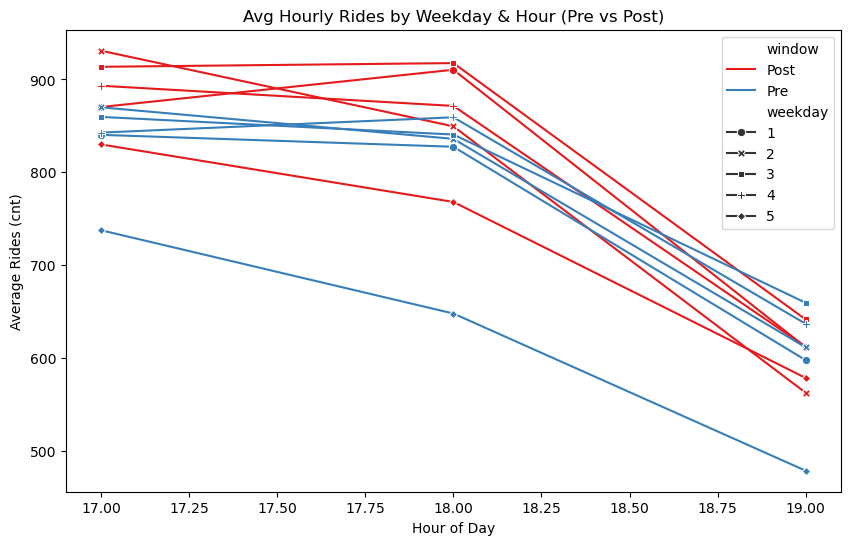

In [21]:
slot_summary = balanced.groupby(['window','weekday','hr'])['cnt'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(
    x='hr', y='cnt', hue='window', style='weekday',
    data=slot_summary, markers=True, dashes=False, palette='Set1'
)
plt.title("Avg Hourly Rides by Weekday & Hour (Pre vs Post)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Rides (cnt)")
plt.savefig('/Users/Marcy_Student/Desktop/Mod4_FinalProject/figures/prepost.png', dpi=150)
plt.show()
